In [64]:
# Inspired by https://sharmaabhishekk.github.io/projects/passmap and
##

## Imports

In [65]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pandas import json_normalize
import numpy as np

import warnings

warnings.filterwarnings("ignore")

## Data Extraction

In [66]:
def load_file(match_id, getter="remote", path=None):
    """
    Load the json file from the local directory or from the remote github repository"""

    if getter == "local":
        with open(f"{path}/{match_id}.json", "r", encoding="utf-8") as f:
            match_dict = json.load(f)
            df = json_normalize(match_dict, sep="_")
            df = df.query("location == location")
            df[["x", "y"]] = pd.DataFrame(df.location.values.tolist(), index=df.index)
            df["y"] = (
                80 - df["y"]
            )  ##Reversing the y-axis co-ordinates because Statsbomb use this weird co-ordinate system
            df["location"] = df[["x", "y"]].apply(list, axis=1)

        return match_dict, df

    elif getter == "remote":
        resp = requests.get(
            f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json"
        )

        match_dict = json.loads(resp.text)
        df = json_normalize(match_dict, sep="_")
        df = df.query("location == location")
        df[["x", "y"]] = pd.DataFrame(df.location.values.tolist(), index=df.index)
        df["y"] = (
            80 - df["y"]
        )  ##Reversing the y-axis co-ordinates because Statsbomb use this reversed co-ordinate system
        df["location"] = df[["x", "y"]].apply(list, axis=1)

        return match_dict, df

## Data Preparing

In [67]:
class Player:
    """
    A class to represent a player in a match
    """

    def __init__(self, player, df):
        self.id = player["player"]["id"]
        self.name = player["player"]["name"]
        self.average_position(df)

    def average_position(self, df):
        player_pass_df = df.query(
            "(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) & (player_id == @self.id) & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])"
        )
        self.x, self.y = np.mean(player_pass_df["location"].tolist(), axis=0)

        self.n_passes_completed = len(player_pass_df)


def get_starters(match_dict, side="home"):
    """
    Get the starting players for a given side
    """

    lineups = (
        match_dict[0]["tactics"]["lineup"]
        if side == "home"
        else match_dict[1]["tactics"]["lineup"]
    )
    return lineups

In [68]:
match_id = 3888705
side = "home"
min_pass_count = 1  ## Minimum number of passes for a link to be plotted

In [69]:
match_dict, df = load_file(match_id)
lineups = get_starters(match_dict, side=side)

side_dict = {
    "home": match_dict[0]["team"]["name"],
    "away": match_dict[1]["team"]["name"],
}

In [70]:
player_objs_dict = {}
starters = []
for player in lineups:
    starters.append(player["player"]["name"])
    p = Player(player, df)
    player_objs_dict.update({player["player"]["name"]: p})

In [71]:
total_pass_df = df.query(
    f"(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) &"
    f"(team_name == '{side_dict[side]}') & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])"
)

total_pass_df = (
    total_pass_df.groupby(["player_name", "pass_recipient_name"])
    .size()
    .reset_index(name="count")
)

total_pass_df = total_pass_df.query(
    " (player_name == @starters) & (pass_recipient_name == @starters) & (count>=@min_pass_count) "
)

In [72]:
lineup_df = json_normalize(lineups, sep="_")[["player_name", "jersey_number"]]

In [73]:
lineup_df

,player_name,jersey_number
0,Gylmar dos Santos Neves,3
1,Dejalma Pereira Dias dos Santos,4
2,Hideraldo Luis Bellini,2
3,Orlando Peçanha de Carvalho,15
4,Nilton dos Reis Santos,12
5,José Ely de Miranda,19
6,Waldyr Pereira,6
7,Manoel Francisco dos Santos,11
8,Mário Jorge Lobo Zagallo,7
9,Édson Arantes do Nascimento,10


In [74]:
total_pass_df = total_pass_df.merge(lineup_df, on="player_name", how="left")

total_pass_df = total_pass_df.merge(
    lineup_df,
    left_on="pass_recipient_name",
    right_on="player_name",
    how="left",
)

In [75]:
total_pass_df.columns = [
    "player_name",
    "pass_recipient_name",
    "count",
    "player_number",
    "pass_recipient_name_y",
    "pass_recipient_number",
]
total_pass_df = total_pass_df[
    [
        "player_name",
        "pass_recipient_name",
        "count",
        "player_number",
        "pass_recipient_number",
    ]
]

In [76]:
total_pass_df.sort_values(by="count", ascending=False)

,player_name,pass_recipient_name,count,player_number,pass_recipient_number
51,Nilton dos Reis Santos,Mário Jorge Lobo Zagallo,15,12,7
73,Édson Arantes do Nascimento,Edvaldo Izidio Neto,14,10,20
45,Mário Jorge Lobo Zagallo,Édson Arantes do Nascimento,13,7,10
13,Edvaldo Izidio Neto,Édson Arantes do Nascimento,12,20,10
3,Dejalma Pereira Dias dos Santos,Manoel Francisco dos Santos,11,4,11
...,...,...,...,...,...
58,Orlando Peçanha de Carvalho,José Ely de Miranda,1,15,19
57,Orlando Peçanha de Carvalho,Gylmar dos Santos Neves,1,15,3
18,Gylmar dos Santos Neves,Orlando Peçanha de Carvalho,1,3,15
19,Gylmar dos Santos Neves,Waldyr Pereira,1,3,6


In [77]:
total_pass_df["player_name"].unique()

array(['Dejalma Pereira Dias dos Santos', 'Edvaldo Izidio Neto',
       'Gylmar dos Santos Neves', 'Hideraldo Luis Bellini',
       'José Ely de Miranda', 'Manoel Francisco dos Santos',
       'Mário Jorge Lobo Zagallo', 'Nilton dos Reis Santos',
       'Orlando Peçanha de Carvalho', 'Waldyr Pereira',
       'Édson Arantes do Nascimento'], dtype=object)

## Data analysis

In [78]:
import networkx as nx
from unidecode import unidecode

In [79]:
G = nx.DiGraph()

edges = [
    (int(row["player_number"]), int(row["pass_recipient_number"]))
    for i, row in total_pass_df.iterrows()
]
weights = [int(row["count"]) for i, row in total_pass_df.iterrows()]


for i in range(len(edges)):
    G.add_edge(edges[i][0], edges[i][1], weight=weights[i])

### Vizualization

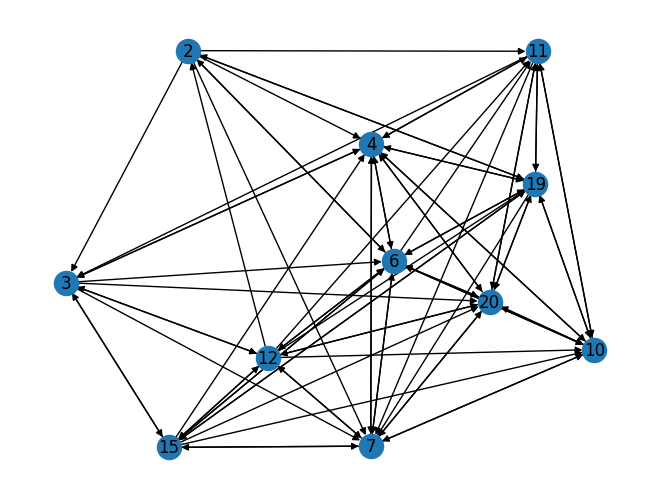

In [80]:
nx.draw(G, with_labels=True)

In [81]:
total_pass_df["x"] = total_pass_df["player_name"].apply(lambda x: player_objs_dict[x].x)
total_pass_df["y"] = total_pass_df["player_name"].apply(lambda x: player_objs_dict[x].y)

total_pass_df["x_end"] = total_pass_df["pass_recipient_name"].apply(
    lambda x: player_objs_dict[x].x
)
total_pass_df["y_end"] = total_pass_df["pass_recipient_name"].apply(
    lambda x: player_objs_dict[x].y
)

In [82]:
popular_names_dict = {
    "Dejalma Pereira Dias dos Santos": "Djalma Santos",
    "Gylmar dos Santos Neves": "Gylmar",
    "Edvaldo Izidio Neto": "Vavá",
    "Hideraldo Luis Bellini": "Bellini",
    "Mário Jorge Lobo Zagallo": "Zagallo",
    "José Ely de Miranda": "Zito",
    "Manoel Francisco dos Santos": "Garrincha",
    "Nilton dos Reis Santos": "Nilton Santos",
    "Orlando Peçanha de Carvalho": "Orlando",
    "Waldyr Pereira": "Didi",
    "Édson Arantes do Nascimento": "Pelé",
}

jersey_number_dict = {
    "Dejalma Pereira Dias dos Santos": 4,
    "Gylmar dos Santos Neves": 3,
    "Edvaldo Izidio Neto": 20,
    "Hideraldo Luis Bellini": 2,
    "Mário Jorge Lobo Zagallo": 7,
    "José Ely de Miranda": 19,
    "Manoel Francisco dos Santos": 11,
    "Nilton dos Reis Santos": 12,
    "Orlando Peçanha de Carvalho": 15,
    "Waldyr Pereira": 6,
    "Édson Arantes do Nascimento": 10,
}
total_pass_df["player_number"] = total_pass_df.apply(
    lambda x: jersey_number_dict[x["player_name"]], axis=1
)
total_pass_df["player_name"] = total_pass_df.apply(
    lambda x: popular_names_dict[x["player_name"]], axis=1
)
total_pass_df.head(3)

,player_name,pass_recipient_name,count,player_number,pass_recipient_number,x,y,x_end,y_end
0,Djalma Santos,Edvaldo Izidio Neto,7,4,20,48.435135,15.394595,76.395455,43.963636
1,Djalma Santos,Gylmar dos Santos Neves,5,4,3,48.435135,15.394595,10.369231,40.261538
2,Djalma Santos,José Ely de Miranda,5,4,19,48.435135,15.394595,67.509756,25.812195


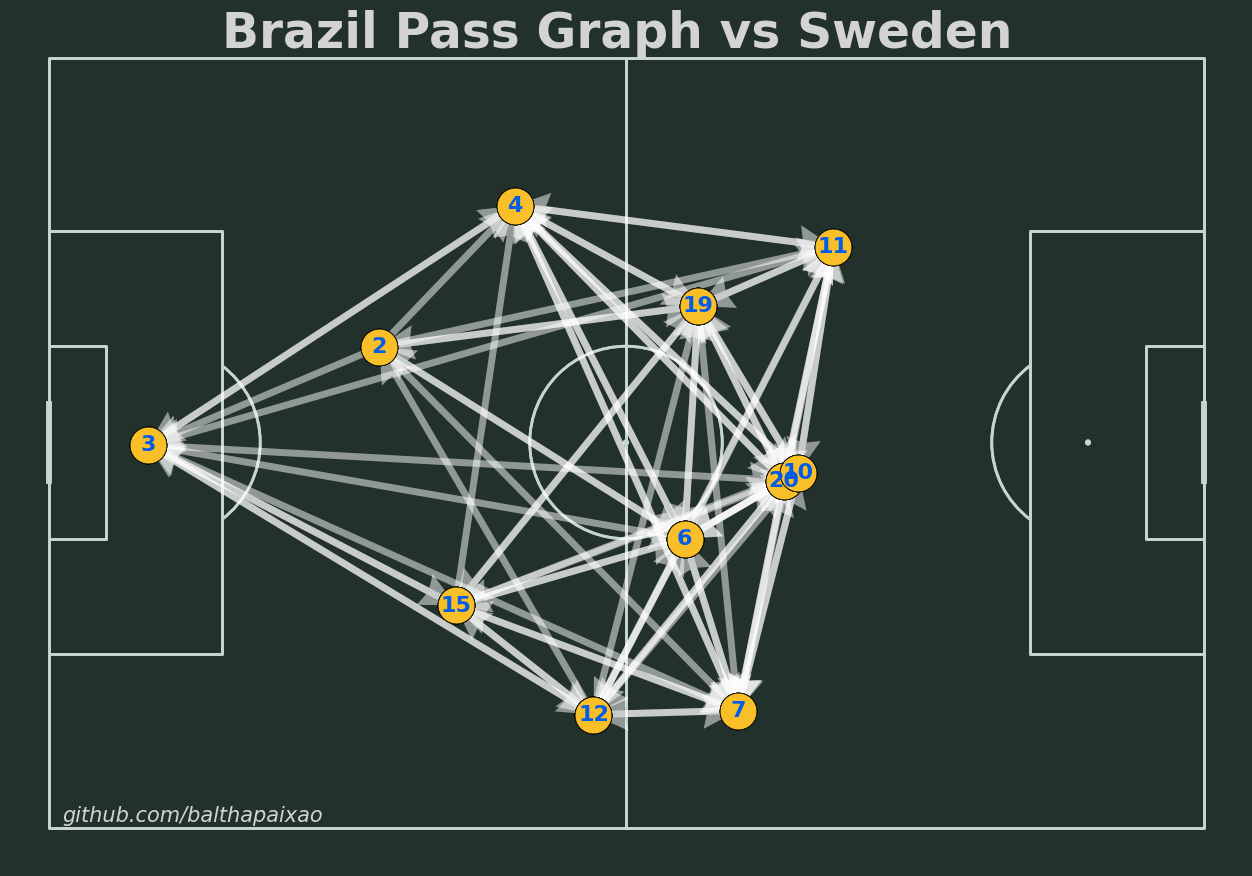

In [83]:
from mplsoccer import Pitch, FontManager, Sbopen

pitch = Pitch(pitch_type="statsbomb", pitch_color="#22312b", line_color="#c7d5cc")
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor("#22312b")

arrows = pitch.arrows(
    total_pass_df["x"],
    total_pass_df["y"],
    total_pass_df["x_end"],
    total_pass_df["y_end"],
    ax=ax,
    width=5,
    headwidth=5,
    color="w",
    zorder=1,
    alpha=0.5,
)

nodes = pitch.scatter(
    total_pass_df["x"],
    total_pass_df["y"],
    ax=ax,
    s=700,
    color="#f9bf28",
    edgecolors="black",
    linewidth=0.5,
    alpha=1,
    zorder=1,
)

s = "Brazil Pass Graph vs Sweden"
ax.text(
    s=s,
    x=18,
    y=-1,
    fontweight="bold",
    fontsize=35,
    color="#d3d3d3",
)

style = dict(size=16, color="#035ce7", weight="bold", ha="center", va="center")
df_avg_locations = total_pass_df.drop_duplicates(subset=["player_name"])
for _, row in df_avg_locations.iterrows():
    ax.text(
        row["x"],
        row["y"],
        row["player_number"],
        **style,
    )

fig.text(
    0.16,
    0.15,
    f"github.com/balthapaixao",
    fontstyle="italic",
    fontsize=15,
    color="#d3d3d3",
)

pitch.draw(ax=ax)

### Complex Networks metrics

### Pagerank

In [84]:
pr = nx.pagerank(G)
pr

{4: 0.09999924053003252,
 20: 0.17705483871439448,
 3: 0.03789944564820552,
 19: 0.10361774160307761,
 11: 0.10549709021228205,
 7: 0.12633841737450263,
 6: 0.10219505149574705,
 10: 0.15103044289028728,
 12: 0.04884566913293764,
 15: 0.02636165281858359,
 2: 0.02116040957994975}

In [85]:
print(f"Player with lower degree -> {min(G.degree(), key=lambda x: x[1])}")
print(f"Player with higher degree -> {max(G.degree(), key=lambda x: x[1])}")
print(f"Average Degree -> {sum(dict(G.degree()).values())/len(G.nodes())}")

print()

print(f"Player with lower in-degree -> {max(G.in_degree(), key=lambda x: x[1])}")
print(f"Player with higher in-degree -> {min(G.in_degree(), key=lambda x: x[1])}")
print(f"Average in-degree -> {sum(dict(G.in_degree()).values())/len(G.nodes())}")

print()

print(f"Player with lower out-degree -> {min(G.out_degree(), key=lambda x: x[1])}")
print(f"Player with higher out-degree -> {max(G.out_degree(), key=lambda x: x[1])}")
print(f"Average out-degree -> {sum(dict(G.out_degree()).values())/len(G.nodes())}")

print()

print(
    f"Player with in-degree above the average -> {[x for x in G.nodes()if G.in_degree(x)>sum(dict(G.in_degree()).values())/len(G.nodes())]}"
)
print(
    f"Player with out-degree above the average -> {[x for x in G.nodes() if G.out_degree(x)>sum(dict(G.out_degree()).values())/len(G.nodes())]}"
)

Player with lower degree -> (2, 9)
Player with higher degree -> (6, 18)
Average Degree -> 14.181818181818182

Player with lower in-degree -> (7, 10)
Player with higher in-degree -> (2, 3)
Average in-degree -> 7.090909090909091

Player with lower out-degree -> (3, 6)
Player with higher out-degree -> (6, 9)
Average out-degree -> 7.090909090909091

Player with in-degree above the average -> [4, 20, 19, 7, 6, 10]
Player with out-degree above the average -> [19, 6, 12, 15]


## Clustering, Closeness and Betweenness

In [86]:
print(
    f"Player with higher clustering -> {max(nx.clustering(G), key=lambda x: nx.clustering(G)[x])}"
)
print(
    f"Player with lower clustering -> {min(nx.clustering(G), key=lambda x: nx.clustering(G)[x])}"
)

print()

print(
    f"Player with higher closeness centrality -> {max(nx.closeness_centrality(G), key=lambda x: nx.closeness_centrality(G)[x])}"
)
print(
    f"Player with lower closeness centrality -> {min(nx.closeness_centrality(G), key=lambda x: nx.closeness_centrality(G)[x])}"
)

print()

print(
    f"Player with higher betweeness centrality -> {max(nx.betweenness_centrality(G), key=lambda x: nx.betweenness_centrality(G)[x])}"
)
print(
    f"Player with lower betweeness centrality -> {min(nx.betweenness_centrality(G), key=lambda x: nx.betweenness_centrality(G)[x])}"
)

Player with higher clustering -> 10
Player with lower clustering -> 3

Player with higher closeness centrality -> 7
Player with lower closeness centrality -> 2

Player with higher betweeness centrality -> 6
Player with lower betweeness centrality -> 2


## Hubs

In [87]:
hubs, authorities = nx.hits(G)

print(f"Player with higher hub -> {max(hubs, key=lambda x: hubs[x])}")
print(f"Player with lower hub -> {min(hubs, key=lambda x: hubs[x])}")

Player with higher hub -> 6
Player with lower hub -> 2


## Authorities

In [88]:
print(
    f"Player with higher authority -> {max(authorities, key=lambda x: authorities[x])}"
)
print(
    f"Player with lower authority -> {min(authorities, key=lambda x: authorities[x])}"
)

Player with higher authority -> 10
Player with lower authority -> 2


In [89]:
graus_list = []
clusters_list = []
hubs_list = []
authorities_list = []
in_list = []
out_list = []
page_rank_list = []
for key in hubs.keys():
    graus_list.append(G.degree(key))
    clusters_list.append(nx.clustering(G)[key])
    hubs_list.append(hubs[key])
    authorities_list.append(authorities[key])
    in_list.append(G.in_degree(key))
    out_list.append(G.out_degree(key))
    page_rank_list.append(round(pr[key], 3))

In [90]:
df_metrics = pd.DataFrame(
    {
        "Degree": graus_list,
        "In": in_list,
        "Out": out_list,
        "Clustering": clusters_list,
        "Hubs": hubs_list,
        "Authorities": authorities_list,
        "PageRank": page_rank_list,
    },
    index=hubs.keys(),
)
df_metrics = df_metrics.sort_index()

In [91]:
df_metrics = df_metrics.merge(lineup_df, left_index=True, right_on="jersey_number")

In [92]:
df_metrics['player_name'] = df_metrics['player_name'].apply(lambda x: popular_names_dict[x])

In [94]:
df_metrics = df_metrics.set_index('player_name')


In [95]:
df_metrics

,Degree,In,Out,Clustering,Hubs,Authorities,PageRank,jersey_number
player_name,,,,,,,,
Bellini,9,3,6,0.735294,0.027534,0.013334,0.021,2
Gylmar,11,5,6,0.673077,0.030166,0.025245,0.038,3
Djalma Santos,16,9,7,0.699115,0.105945,0.071837,0.100,4
Didi,18,9,9,0.679310,0.135303,0.108029,0.102,6
Zagallo,16,10,6,0.723684,0.121792,0.142394,0.126,7
Pelé,14,8,6,0.835294,0.123114,0.179005,0.151,10
Garrincha,13,7,6,0.763514,0.044132,0.124757,0.105,11
Nilton Santos,14,5,9,0.691860,0.092302,0.044843,0.049,12
Orlando,13,5,8,0.753425,0.065355,0.017837,0.026,15
